<a href="https://colab.research.google.com/github/jjordana/twitter_sentiment_analysis/blob/master/firstTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **First Approach**

After performing our [EDA](https://github.com/jjordana/twitter_sentiment_analysis/blob/master/EDA.ipynb), our next step is going to be to try to achieve some of the target data (_selected_text_).<br>
We will be using the previous output data.


## Importin Data, Libraries & More

In [67]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import random
import re, string

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('vader_lexicon') # For the counterPlots
        
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [0]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')

We can check that we have all the data comming from the previous notebook. However, as we are not focus (well, not too much) on keep exploring our data, we are going to remove the columns corresponding to the `jaccScore`, `polarityScore` and `subjectivity`.


In [56]:
train = train.drop(columns=['Unnamed: 0', 'jaccScore', 'polarityScore', 'subjectivity'])
print(train['sentiment'].value_counts())
train.head()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


,textID,text,selected_text,sentiment,newText,newSelection
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i`d have responded if i were going,i`d have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego,so sad
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldn`t they put them on the re...,sons of


We know that our dataset is a little bit `imbalanced`. This casuistics usually give us some difficulties when we try to solve it with the common algorightms. Tipical algorithms tend to focustowards the majority class, and the often do not considerate the data distribution. A good solution to deal this issue is to `oversample` or `undersample` each class. <br>
Nevertheless, as this is our first try, we are not going to change anything, just to see what happens.

In most of NLP processes, tokenization and lemmatization is a must. Therefore, let's go ahead with them. <br>
We are going to tokenize and lemmatize either the raw data (the one comming from the [Kaggle's competition](https://www.kaggle.com/c/tweet-sentiment-extraction)) and the traeted data _newText_ and _newSelection_ (result of cleaning all the not desired characters and applying a previous lemmatization).

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in str(text).lower().split(" ") if token != "" if token not in STOPWORDS]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    lemmatized_words = []
    for val in tokens:
        val = lemmatizer.lemmatize(val,pos ="a")
        val = lemmatizer.lemmatize(val,pos ="n")
        val = lemmatizer.lemmatize(val,pos ="v")
        lemmatized_words.append(val)
    return lemmatized_words

In [0]:
# Raw Data
train['textToken'] = train['text'].apply(tokenization)
train['selectedTextToken'] = train['selected_text'].apply(tokenization)
train['textToken'] = train['textToken'].apply(lemmatization)
train['selectedTextToken'] = train['selectedTextToken'].apply(lemmatization)

# Treated Data
train['newTextToken'] = train['newText'].apply(tokenization)
train['newSelectedTextToken'] = train['newSelection'].apply(tokenization)
train['newTextToken'] = train['newTextToken'].apply(lemmatization)
train['newSelectedTextToken'] = train['newSelectedTextToken'].apply(lemmatization)

How similar are our `selected_text` and `newSelecttion` tokens?<br>
Let's plot a simple graph to have an idea comparing their jaccard score.

In [0]:
def jaccardScore(a, b):  
  try:
    intersect = list(set(a).intersection(b)) # Common values between A and B
    union = len(a) + len(b) - len(intersect) # Values of A and B witout commons
    return round((len(intersect) / union), 2)
  except: # For those cases in which our tweet is mainly composed of STOPWORDS
    return 1

In [0]:
train['jaccScore'] = train.apply(lambda x: jaccardScore(x.selectedTextToken, x.newSelectedTextToken), axis=1)

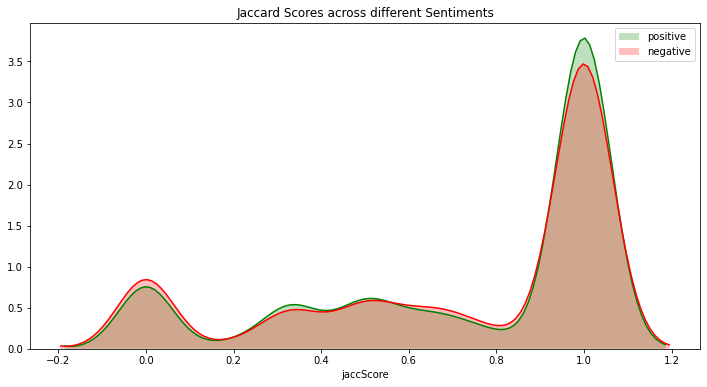

In [61]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)

plt.legend(labels=['positive','negative'])

Interesting.<br>
We can see that the jaccar score is well distributed, but in any case it behaves in the same way for positive and negative tweets. <br>
Besides, is seems that in the majority of the cases our `newSelection` and `selection_text` have a high similarity.

If we plot also neutral tweets, we can see that it's behavour is more arbitrary.

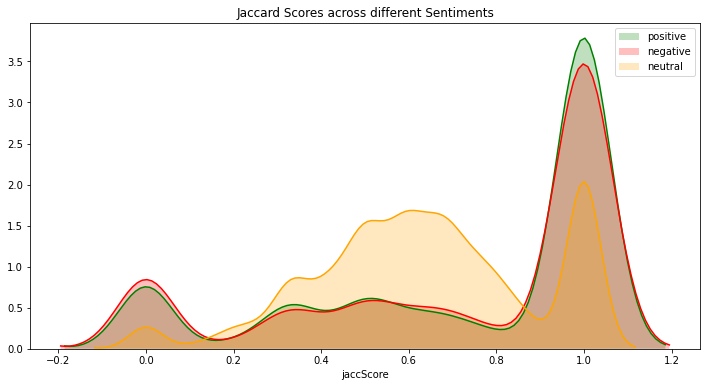

In [62]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)
p2=sns.distplot(train[train['sentiment']=='neutral']['jaccScore'], kde_kws={"shade": True}, color="orange", hist=False)


plt.legend(labels=['positive','negative', 'neutral'])

We are going to try to get all the selected_words just using our tokens. <br>
As we saw before, there is an interesting score value called `polarity_score`. It gives information about how positive, neutral or negative is a word. Besides, there is another metric `compound` which merges all the weights for the given word. 

By calculating our polarity score we might be able to achieve some kind of good result.<br>
Firstly, we will tokenize our raw text __maintaning the STOPWORDS__. This time we want to keep all the data.<br>
Secondly, we will divide our study in three main parts. The division will be performed by sentiment. As we have seen before, neutral sentiment tweets behave randomyl. Therefore we must analyze them separetly.

In [0]:
df = train[['text', 'selected_text', 'sentiment', 'newText', 'newSelection']]

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in str(text).lower().split(" ") if token != ""]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

# Function for getting the score of the whole tweet
def sentiment_analyzer_scores(tokens):
  scores = []
  for word in tokens:
    score = sid.polarity_scores(str(word))
    score = score['compound']
    scores.append(score)
  return scores

In [0]:
df['token'] = df['newText'].apply(tokenization)
df['tokenScore'] = df['token'].apply(sentiment_analyzer_scores)

For each token we want to calculate its polarity score. 
If the tweet is positive or negative, we will focus on those scores that have the highest value. That value would be key for determining from where do we start getting our first seelcted word.

However, how do we know how many words do we need to get? This is difficult to get.<br>
For the moment, we will try to plot if there is any realtion between the `selected_text` and the `text` lengths. 

### Positive

In [0]:
df1 = df[df.sentiment=='positive']

In [0]:
cc = pd.DataFrame(df1['text'].str.split().apply(len).value_counts())
cc['length'] = cc.index
cc = cc.reset_index().drop(columns=['index']).sort_values(by='length').rename(columns={'text':'count'})

In [198]:
cc

,count,length
27,46,1
22,161,2
20,247,3
12,344,4
9,374,5
3,451,6
0,492,7
2,475,8
1,487,9
5,425,10


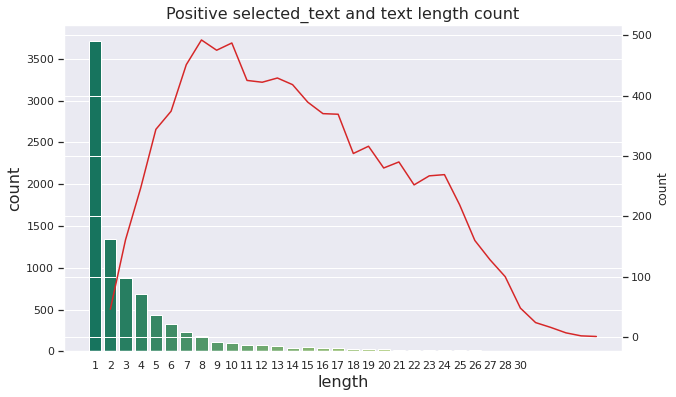

In [215]:
count = pd.DataFrame(df1['selected_text'].str.split().apply(len).value_counts())
count['length'] = count.index
count = count.reset_index().drop(columns=['index']).sort_values(by='length').rename(columns={'selected_text':'count'})

fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Positive selected_text and text length count', fontsize=16)
ax1.set_xlabel('Length', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)
ax1 = sns.barplot(x='length', y="count", data=count, palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2 = sns.lineplot(x='length', y='count', data = cc, color=color)
ax2.tick_params(axis='x')

#show plot
plt.show()

# my_palette = sns.color_palette("muted")
# sns.set(rc={'figure.figsize':(10, 7)})
# sns.barplot(x='length', y="count", data=count, palette=my_palette) .set_title('Positive selected_text Word Count', fontsize=16)


In [171]:
"Wow... u just became cooler.".split()

['Wow...', 'u', 'just', 'became', 'cooler.']

In [0]:
def decider(tokensScore, sentiment):
  if sentiment == 'positive':
    values = [item for item in tokensScore if item >= 0]
    maxVal = max(values)

In [161]:
a = [item for item in [0.2023, -0.3182, 0.0, 0.0, 0.0, 0.4019, 0.0] if item >= 0]
print(max([0.2023, -0.3182, 0.0, 0.0, 0.0, 0.4019, 0.0]))

0.4019


In [153]:
df1 = df[df.sentiment=='positive']
df1

,text,selected_text,sentiment,newText,newSelection,token,tokenScore
6,2am feedings for the baby are fun when he is a...,fun,positive,2am feedings for the baby are fun when he is a...,fun,"[2am, feedings, for, the, baby, are, fun, when...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5106, 0.0, 0...."
9,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,journey wow u just became cooler hehe is tha...,wow u just became cooler,"[journey, wow, u, just, became, cooler, hehe, ...","[0.0, 0.5859, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
11,I really really like the song Love Story by Ta...,like,positive,i really really like the song love story by ta...,like,"[i, really, really, like, the, song, love, sto...","[0.0, 0.0, 0.0, 0.3612, 0.0, 0.0, 0.6369, 0.0,..."
21,Playing Ghost Online is really interesting. Th...,interesting.,positive,playing ghost online is really interesting the...,interesting,"[playing, ghost, online, is, really, interesti...","[0.2023, -0.3182, 0.0, 0.0, 0.0, 0.4019, 0.0, ..."
25,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,the free fillin` app on my ipod is fun im addi...,the free fillin` app on my ipod is fun im addi...,"[the, free, fillin`, app, on, my, ipod, is, fu...","[0.0, 0.5106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
...,...,...,...,...,...,...,...
27466,morning twit-friends! welcome to my new followers,welcome,positive,morning twitfriends welcome to my new followers,welcome,"[morning, twitfriends, welcome, to, my, new, f...","[0.0, 0.0, 0.4588, 0.0, 0.0, 0.0, 0.0]"
27473,So I get up early and I feel good about the da...,I feel good ab,positive,so i get up early and i feel good about the da...,i feel good ab,"[so, i, get, up, early, and, i, feel, good, ab...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.440..."
27474,enjoy ur night,enjoy,positive,enjoy ur night,enjoy,"[enjoy, ur, night]","[0.4939, 0.0, 0.0]"
27477,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you...,yay good for both of you,"[yay, good, for, both, of, you, enjoy, the, br...","[0.5267, 0.4404, 0.0, 0.0, 0.0, 0.0, 0.4939, 0..."


In [91]:
df[df['sentiment']!='neutral'][20:30]

,text,selected_text,sentiment,newText,newSelection,token,tokenScore
31,i hope unni will make the audition . fighting ...,hope,positive,i hope unni will make the audition fighting d...,hope,"[i, hope, unni, will, make, the, audition, fig...","[0.0, 0.4404, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3612..."
32,If it is any consolation I got my BMI tested ...,well so much for being unhappy for about 10 mi...,negative,if it is any consolation i got my bmi tested ...,well so much for being unhappy for about 10 mi...,"[if, it, is, any, consolation, i, got, my, bmi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
33,That`s very funny. Cute kids.,funny.,positive,that`s very funny cute kids,funny,"[that`s, very, funny, cute, kids]","[0.0, 0.0, 0.4404, 0.4588, 0.0]"
36,Born and raised in NYC and living in Texas for...,miss,negative,born and raised in nyc and living in texas for...,miss,"[born, and, raised, in, nyc, and, living, in, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
38,i`m soooooo sleeeeepy!!! the last day o` schoo...,soooooo sleeeeepy!!!,negative,i`m so slepy the last day o` school was todays...,so slepy,"[i`m, so, slepy, the, last, day, o`, school, w...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39,A little happy for the wine jeje ok it`sm my f...,A little happy fo,positive,a little happy for the wine jeje ok it`sm my f...,a little happy fo,"[a, little, happy, for, the, wine, jeje, ok, i...","[0.0, 0.0, 0.5719, 0.0, 0.0, 0.0, 0.0, 0.296, ..."
41,im an avid fan of **** magazine and i love you...,avid fan of,positive,im an avid fan of magazine and i love your ma...,avid fan of,"[im, an, avid, fan, of, magazine, and, i, love...","[0.0, 0.0, 0.296, 0.3182, 0.0, 0.0, 0.0, 0.0, ..."
44,I love to! But I`m only available from 5pm. ...,I love to!,positive,i love to but i`m only available from 5pm an...,i love to,"[i, love, to, but, i`m, only, available, from,...","[0.0, 0.6369, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
46,egh blah and boooooooooooo i dunno wanna go to...,SUCKKKKKK,negative,egh blah and bo i dunno wanna go to work hang...,suckkkkkk,"[egh, blah, and, bo, i, dunno, wanna, go, to, ...","[0.0, -0.1027, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
48,"i donbt like to peel prawns, i also dont like ...",dont like go,negative,i donbt like to peel prawns i also dont like g...,dont like go,"[i, donbt, like, to, peel, prawns, i, also, do...","[0.0, 0.0, 0.3612, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


In [73]:
for val in ['so', 'sad', 'i', 'will ', 'miss', 'you', 'here', 'in', 'san', 'diego']:
  print(val, ": ", sid.polarity_scores(str(val)))

so :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sad :  {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4767}
i :  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
will  :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
miss :  {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.1531}
you :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
here :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
in :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
san :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
diego :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
